# Surface Projection

We explore the toy example of learning a surface, represented by a set of 2D points $\{(x_i, y_i) \in \mathbb{R}^2 \mid i = 1, \ldots, m\}$, such that the projection of the surface onto the nearest ellipsoid has maximum volume (area in 2D) and unit surface area (circumference in 2D). We know that the solution to such a problem is a sphere. For our problem we will restrict the ellipsoid in 2D to be axis-aligned and represent it by the length of each axis $a$ and $b$. Given this representation the area of the ellipse is

$$
A = \pi a b
$$

and circumference approximated by

$$
C \approx \pi \left( 3(a + b) - \sqrt{(3a + b)(a + 3b)} \right).
$$

Full details and other approximations are discussed on [Wikipedia](https://en.wikipedia.org/wiki/Ellipse).

## Projection onto constrained ellipse

The nearest ellipse (parametrized by $(a, b)$), with unit circumference, to the set of points $\{(x_i, y_i)\}$ can be found in the least-squares sense,

$$
\begin{array}{ll}
  \text{minimize (over $a, b$)} & \sum_{i=1}^{m} \left(\frac{x_i^2}{a^2} + \frac{y_i^2}{b^2} - 1\right)^2 \\
  \text{subject to} & 3\pi(a + b) - \pi\sqrt{(3a + b)(a + 3b)} = 1
\end{array}
$$

which can be written in standard form as

$$
\begin{array}{ll}
  \text{minimize} & \|A u - \mathbf{1}_m\|^2 \\
  \text{subject to} & 3\pi\left(\frac{1}{\sqrt{u_1}} + \frac{1}{\sqrt{u_2}}\right) - \pi\sqrt{\left(\frac{3}{\sqrt{u_1}} + \frac{1}{\sqrt{u_2}}\right)\left(\frac{1}{\sqrt{u_1}} + \frac{3}{\sqrt{u_2}}\right)} = 1
\end{array}
$$

where

$$
A = \begin{bmatrix}
  x_1^2 & y_1^2 \\
  \vdots & \vdots \\
  x_m^2 & y_m^2
\end{bmatrix}
$$

and $u = \left(\frac{1}{a^2}, \frac{1}{b^2}\right)$.


## Bilevel optimization

Our overall problem can then be stated as

$$
\begin{array}{ll}
  \text{minimize (over $\{(x_i, y_i)\}$)} & \sqrt{u_1^\star u_2^\star} \\
  \text{subject to} & u^\star = \text{argmin} \; \|Au - \mathbf{1}_m\|^2 \\
  & \hphantom{y =} \text{subject to} \; 3\pi\left(\sqrt{u_1} + \sqrt{u_2}\right) - \pi\sqrt{\left(3\sqrt{u_1} + \sqrt{u_2}\right)\left(\sqrt{u_1 }+ 3\sqrt{u_2}\right)} - \sqrt{u_1 u_2} = 0
\end{array}
$$

where we have stated the lower-level problem in terms of $u$ rather than $(a, b)$, and therefore instead of maximizing $\pi a b$, we minimize $\sqrt{u_1 u_2} = \frac{1}{ab}$.

Ellipse (0.25, 0.1) has area 0.0785 and circumference 1.15.
Ellipse estimate (0.209, 0.0993) has area 0.0653 and circumference 1.0.


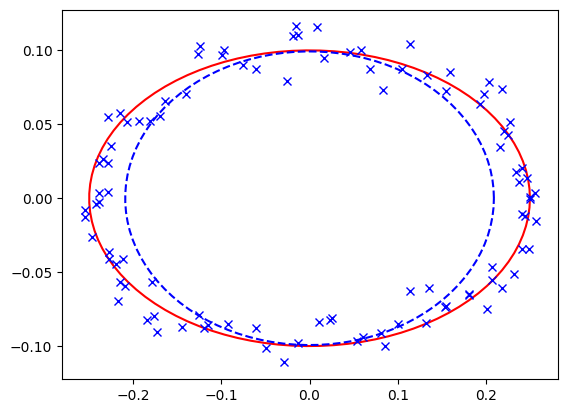

In [127]:
import math
import numpy as np
import scipy.optimize as opt
import torch

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# ellipse area and circumference
def ellipse_area(a, b):
    """Returns the area of an ellipse parametrized as (x/a)^2 + (y/b)^2 = 1."""
    return math.pi * a * b

def ellipse_circum(a, b):
    """Returns the approximate circumference of an ellipse."""
    return 3.0 * math.pi * (a + b) - math.pi * math.sqrt((3.0 * a + b) * (a + 3.0 * b))

# ellipse plotting
def plot_ellipse(a, b, style='--'):
    """Plot an ellipse parametrized by (a, b)."""
    t = 2.0 * math.pi * torch.linspace(0.0, 1.0, 100)
    plt.plot(a * torch.cos(t), b * torch.sin(t), style)

# ellipse fitting
def fit_ellipse(data):
    """Find ellipse parameters u = (1/a^2, 1/b^2) that best fit the data."""
    A = data.T ** 2
    b = torch.ones(A.shape[0])
    
    # compute unconstrained solution as an initialization
    u0 = torch.linalg.lstsq(A, b)[0]

    # now enforce constraints
    eq_const = {'type': 'eq',
                'fun' : lambda u: torch.tensor([1]) if (torch.any(torch.tensor(u) < 0.0)) else np.array([3.0 * math.pi * (math.sqrt(u[0]) + math.sqrt(u[1])) - 
                        math.pi * math.sqrt((3.0 * math.sqrt(u[0]) + math.sqrt(u[1])) * (math.sqrt(u[0]) + 3.0 * math.sqrt(u[1]))) - math.sqrt(u[0] * u[1])])}
    #eq_const = {'type': 'eq',
    #            'fun' : lambda u: np.array([ellipse_circum(1.0 / math.sqrt(u[0]), 1.0 / math.sqrt(u[1])) - 1.0])}
    res = opt.minimize(lambda u: torch.sum((A @ u - b) ** 2), torch.tensor(u0).double(), method='SLSQP', constraints=[eq_const], 
                       options={'ftol': 1e-9, 'disp': False})
    return torch.tensor(res.x)

# sample a noisy ellipse
m = 100
a, b = 0.25, 0.1
nu = 1.0e-2

print("Ellipse ({:0.3}, {:0.3}) has area {:0.3} and circumference {:0.3}.".format(a, b, ellipse_area(a, b), ellipse_circum(a, b)))

t = 2.0 * math.pi * torch.linspace(0.0, 1.0, m)
data = torch.stack((a * torch.cos(t), b * torch.sin(t)), dim=0)
data = data + nu * torch.randn(2, m)

plt.figure()
plot_ellipse(a, b, 'r')
plt.plot(data[0], data[1], 'bx')

u = fit_ellipse(data)
a_hat = torch.sqrt(1.0 / u[0])
b_hat = torch.sqrt(1.0 / u[1])
plot_ellipse(a_hat, b_hat, 'b--')

print("Ellipse estimate ({:0.3}, {:0.3}) has area {:0.3} and circumference {:0.3}.".format(a_hat, b_hat, ellipse_area(a_hat, b_hat), ellipse_circum(a_hat, b_hat)))

plt.show()

# Derivatives

Computing gradients by hand is tedious so we'll rely on autograd. Here we make use of the infrastructure provided in `ddn.basic.node` from the DDN respoitory (https://github.com/anucvml/ddn). **Requires `ddn` to be installed.**


In [200]:
# set correct location for DDN repository code and import basic node functionality
import sys
sys.path.append("../../../ddn/")
from ddn.basic.node import *
    
class EllipseConstrainedProjectionNode(EqConstDeclarativeNode):
    """A DDN node for the constrained ellipse projection problem. Gradients will be calculated automatically."""

    def __init__(self, n):
        super().__init__(2 * n, 2) # make sure node is properly constructed
        self.eps = 1.0e-4 # relax tolerance on optimality test

    def objective(self, x, y):
        data = x.reshape(2, -1)
        A = data.T ** 2
        b = torch.ones(A.shape[0])
        return torch.sum((A @ y - b) ** 2)

    def constraint(self, x, y):
        return 3.0 * math.pi * (np.sqrt(y[0]) + np.sqrt(y[1])) - \
            math.pi * np.sqrt((3.0 * np.sqrt(y[0]) + np.sqrt(y[1])) * (np.sqrt(y[0]) + 3.0 * np.sqrt(y[1]))) - np.sqrt(y[0] * y[1])
    
    def solve(self, x):
        assert(len(x) == self.dim_x)
        data = x.reshape(2, -1)
        A = (data.T ** 2).detach().numpy()
        b = np.ones(A.shape[0])

        # compute unconstrained solution as an initialization
        u0 = np.double(np.linalg.lstsq(A, b)[0])
        
        # now enforce constraints
        eq_const = {'type': 'eq',
                    'fun' : lambda u: torch.tensor([1]) if (torch.any(torch.tensor(u) < 0.0)) else np.array([3.0 * math.pi * (math.sqrt(u[0]) + math.sqrt(u[1])) - 
                            math.pi * math.sqrt((3.0 * math.sqrt(u[0]) + math.sqrt(u[1])) * (math.sqrt(u[0]) + 3.0 * math.sqrt(u[1]))) - math.sqrt(u[0] * u[1])])}
        #eq_const = {'type': 'eq',
        #            'fun' : lambda u: np.array([ellipse_circum(1.0 / math.sqrt(u[0]), 1.0 / math.sqrt(u[1])) - 1.0])}
        
        
        
        print("Initial guess x0:", u0)

        # Check the shape of the initial guess
        print("Shape of initial guess x0:", u0.shape)

        # Check the data type of the initial guess
        print("Data type of initial guess x0:", u0.dtype)

        # Verify the constraints
        print("Constraint function:", eq_const['fun'](u0))

        res = opt.minimize(lambda u: np.sum((A @ u - b) ** 2), 
                           u0, 
                           method='SLSQP', 
                           constraints=[eq_const], 
                           options={'ftol': 1e-9, 'disp': False})

        return torch.tensor(res.x), None
    
    
class EllipseInverseAreaNode(AbstractNode):
    """DDN node for computing one over the area of an ellipse."""
    def __init__(self):
        super().__init__(2, 1)

    def solve(self, x):
        return torch.sqrt(x[0] * x[1]), None

    def gradient(self, x, y=None, ctx=None):
        z = 2.0 * torch.sqrt(x[0] * x[1])
        return torch.tensor([x[1] / z, x[0] / z])


# Optimizing

We now optimize the inital samples in a direction to maximize the area of the projected ellipse using gradient descent.

In [201]:
from ddn.basic.composition import ComposedNode
from copy import deepcopy

node = ComposedNode(EllipseConstrainedProjectionNode(m), EllipseInverseAreaNode())

x_init = data.flatten()
y_init, _ = node.solve(x_init)
history = [y_init]

x = deepcopy(x_init)
x = torch.tensor(x, requires_grad=True)
for i in range(10):
    y, _ = node.solve(x)
    history.append(y)

    if True:
        u = fit_ellipse(x.reshape(2, -1))
        a_hat = math.sqrt(1.0 / u[0])
        b_hat = math.sqrt(1.0 / u[1])
        print("{:5d}: ellipse estimate ({:0.3}, {:0.3}) has area {:0.3} and circumference {:0.3}.".format(i, a_hat, b_hat, ellipse_area(a_hat, b_hat), ellipse_circum(a_hat, b_hat)))
    print(type(x), type(y))
    dLdx = node.gradient(x, y)
    x -= 1.0e-2 * dLdx.flatten()
    
# plot results
plt.figure()
#plt.semilogy(history, lw=2)

plot_ellipse(a, b, 'r')
plt.plot(data[0], data[1], 'bx')

final_data = x.reshape(2, -1)
plt.plot(final_data[0], final_data[1], 'g+')

u = fit_ellipse(final_data)
a_hat = math.sqrt(1.0 / u[0])
b_hat = math.sqrt(1.0 / u[1])
plot_ellipse(a_hat, b_hat, 'g--')

print("Final ellipse ({:0.3}, {:0.3}) has area {:0.3} and circumference {:0.3}.".format(a_hat, b_hat, ellipse_area(a_hat, b_hat), ellipse_circum(a_hat, b_hat)))
plt.axis('square')
plt.legend(['initial true', 'initial samples', 'final samples', 'final projected'])
plt.show()

Initial guess x0: [16.14638772 95.64680512]
Shape of initial guess x0: (2,)
Data type of initial guess x0: float64
Constraint function: [5.9606487]
Initial guess x0: [16.14638772 95.64680512]
Shape of initial guess x0: (2,)
Data type of initial guess x0: float64
Constraint function: [5.9606487]


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.